In [1]:
import nest_asyncio
nest_asyncio.apply()
from pydantic_ai import Agent, RunContext
from pydantic_ai.models.openai import OpenAIModel
from pydantic_ai.providers.openai import OpenAIProvider

In [2]:

ollama_model = OpenAIModel(
    model_name='qwen2.5-coder:14b', provider=OpenAIProvider(base_url='http://localhost:11434/v1')
)

roulette_agent = Agent(  
    ollama_model,
    deps_type=int,
    result_type=bool,
    system_prompt=(
        'Use the `roulette_wheel` function to see if the '
        'customer has won based on the number they provide.'
    )
)

In [3]:
ROULETTE_NUMBERS = 37
import random

@roulette_agent.tool
def roulette_wheel(ctx: RunContext[int], number: int) -> bool:
    # generate random numbers between 0 and 36
    winning_numbers = [random.randint(0, ROULETTE_NUMBERS) for _ in range(19)]

    # if 0 < number < ROULETTE_NUMBERS:
    #     raise ValueError(f'Number must be between 0 and {ROULETTE_NUMBERS}')
    print(f'Winning numbers: {winning_numbers}')
    print(f'User number: {number}')
    print(f'deps: {ctx.deps}')
    return number in winning_numbers

In [4]:
result = roulette_agent.run_sync("is fifteen a winning number", deps=15)

Winning numbers: [1, 34, 17, 32, 1, 1, 6, 22, 11, 36, 24, 1, 36, 6, 34, 0, 20, 5, 31]
User number: 15
deps: 15


In [5]:
result

AgentRunResult(data=False)

using iter

In [6]:
import nest_asyncio
nest_asyncio.apply()
from pydantic_ai import Agent, RunContext
from pydantic_ai.models.openai import OpenAIModel
from pydantic_ai.providers.openai import OpenAIProvider
import pprint as pp

In [7]:
from pydantic_ai import Agent

ollama_model = OpenAIModel(
    model_name='qwen2.5-coder:14b', provider=OpenAIProvider(base_url='http://localhost:11434/v1')
)
agent = Agent(ollama_model)


nodes = []

# Begin an AgentRun, which is an async-iterable over the nodes of the agent's graph
async with agent.iter('What is the capital of France?') as agent_run:
    async for node in agent_run:
        # Each node represents a step in the agent's execution
        nodes.append(node)
pp.pprint(nodes)
"""
    [
        ModelRequestNode(
            request=ModelRequest(
                parts=[
                    UserPromptPart(
                        content='What is the capital of France?',
                        timestamp=datetime.datetime(...),
                        part_kind='user-prompt',
                    )
                ],
                kind='request',
            )
        ),
        CallToolsNode(
            model_response=ModelResponse(
                parts=[TextPart(content='Paris', part_kind='text')],
                model_name='gpt-4o',
                timestamp=datetime.datetime(...),
                kind='response',
            )
        ),
        End(data=FinalResult(data='Paris', tool_name=None, tool_call_id=None)),
    ]
"""

pp.pprint(agent_run.result.data)
#> Paris

[ModelRequestNode(request=ModelRequest(parts=[UserPromptPart(content='What is '
                                                                     'the '
                                                                     'capital '
                                                                     'of '
                                                                     'France?',
                                                             timestamp=datetime.datetime(2025, 3, 7, 19, 25, 13, 25883, tzinfo=datetime.timezone.utc),
                                                             part_kind='user-prompt')],
                                       kind='request')),
 CallToolsNode(model_response=ModelResponse(parts=[TextPart(content='The '
                                                                    'capital '
                                                                    'of France '
                                                                    'is Paris.

In [8]:
import nest_asyncio
nest_asyncio.apply()
from pydantic_ai import Agent, RunContext
from pydantic_ai.models.openai import OpenAIModel
from pydantic_ai.providers.openai import OpenAIProvider
import pprint as pp

In [9]:
from dataclasses import dataclass

import httpx

from pydantic_ai import Agent
ollama_model = OpenAIModel(
    model_name='qwen2.5-coder:14b', provider=OpenAIProvider(base_url='http://localhost:11434/v1')
)
agent = Agent(ollama_model)

@dataclass
class MyDeps:  
    api_key: str
    http_client: httpx.AsyncClient



async with httpx.AsyncClient() as client:
    deps = MyDeps('foobar', client)
    result = await agent.run(
        'Tell me a joke.',
        deps=deps,  
    )
    pp.pprint(result.data)
    #> Did you hear about the toothpaste scandal? They called it Colgate.

("Sure, here's a light-hearted joke for you:\n"
 '\n'
 'Why did the tomato turn red?\n'
 '\n'
 'Because it saw the salad dressing! \n'
 '\n'
 "I hope you found that amusing! If you'd like to hear more jokes or have any "
 'other questions, feel free to ask.')


In [10]:
@dataclass
class MyDeps:
    api_key: str
    http_client: httpx.AsyncClient


agent = Agent(
    ollama_model,
    deps_type=MyDeps,
)


@agent.system_prompt  
async def get_system_prompt(ctx: RunContext[MyDeps]) -> str:  
    response = await ctx.deps.http_client.get(  
        'https://example.com',
        headers={'Authorization': f'Bearer {ctx.deps.api_key}'},  
    )
    response.raise_for_status()
    return f'Prompt: {response.text}'


async with httpx.AsyncClient() as client:
    deps = MyDeps('foobar', client)
    result = await agent.run('Tell me a joke.', deps=deps)
    pp.pprint(result.data)
        #> Did you hear about the toothpaste scandal? They called it Colgate.

"Why couldn't the bicycle stand up by itself? Because it was two-tired!"


In [11]:
import nest_asyncio
nest_asyncio.apply()
from pydantic_ai import Agent, RunContext
from pydantic_ai.models.openai import OpenAIModel
from pydantic_ai.providers.openai import OpenAIProvider
import pprint as pp

In [12]:
from pydantic_ai.common_tools.duckduckgo import duckduckgo_search_tool
from pydantic_ai import Agent
ollama_model = OpenAIModel(
    model_name='qwq:32b', provider=OpenAIProvider(base_url='http://localhost:11434/v1')
)
agent = Agent(ollama_model)
agent = Agent(
    ollama_model,
    tools=[duckduckgo_search_tool()],
    system_prompt='Search DuckDuckGo for the given query and return the results.',
)

result = agent.run_sync(
    'Can you list the top five highest-grossing animated films of 2025?'
)
print(result.data)
"""
I looked into several sources on animated box‐office performance in 2025, and while detailed
rankings can shift as more money is tallied, multiple independent reports have already
highlighted a couple of record‐breaking shows. For example:

• Ne Zha 2 – News outlets (Variety, Wikipedia's "List of animated feature films of 2025", and others)
    have reported that this Chinese title not only became the highest‑grossing animated film of 2025
    but also broke records as the highest‑grossing non‑English animated film ever. One article noted
    its run exceeded US$1.7 billion.
• Inside Out 2 – According to data shared on Statista and in industry news, this Pixar sequel has been
    on pace to set new records (with some sources even noting it as the highest‑grossing animated film
    ever, as of January 2025).

Beyond those two, some entertainment trade sites (for example, a Just Jared article titled
"Top 10 Highest-Earning Animated Films at the Box Office Revealed") have begun listing a broader
top‑10. Although full consolidated figures can sometimes differ by source and are updated daily during
a box‑office run, many of the industry trackers have begun to single out five films as the biggest
earners so far in 2025.

Unfortunately, although multiple articles discuss the "top animated films" of 2025, there isn't yet a
single, universally accepted list with final numbers that names the complete top five. (Box‑office
rankings, especially mid‑year, can be fluid as films continue to add to their totals.)

Based on what several sources note so far, the two undisputed leaders are:
1. Ne Zha 2
2. Inside Out 2

The remaining top spots (3–5) are reported by some outlets in their "Top‑10 Animated Films"
lists for 2025 but the titles and order can vary depending on the source and the exact cut‑off
date of the data. For the most up‑to‑date and detailed ranking (including the 3rd, 4th, and 5th
highest‑grossing films), I recommend checking resources like:
• Wikipedia's "List of animated feature films of 2025" page
• Box‑office tracking sites (such as Box Office Mojo or The Numbers)
• Trade articles like the one on Just Jared

To summarize with what is clear from the current reporting:
1. Ne Zha 2
2. Inside Out 2
3–5. Other animated films (yet to be definitively finalized across all reporting outlets)

If you're looking for a final, consensus list of the top five, it may be best to wait until
the 2025 year‑end box‑office tallies are in or to consult a regularly updated entertainment industry source.

Would you like help finding a current source or additional details on where to look for the complete updated list?
"""

<think>
Alright, let me tackle this query about the top five highest-grossing animated films of 2025. The user is asking for a list that's specific to 2025, which means I need to ensure the data provided pertains accurately to that year.

First, looking at the tool responses from DuckDuckGo, several sources are cited. Wikipedia mentions "Ne Zha 2" surpassing other films and becoming the highest-grossing animated film as of early 2025. Another entry on JustJared lists "Ne Zha 2" with a gross of $1.72 billion as of February 20, 2025. This suggests it's at the top.

Next, there are mentions of other films like "Inside Out 2" being noted in one source as the highest even though Ne Zha 2 overtook it. The Wikipedia entry about box office number ones in the U.S. lists "Captain America: Brave New World" as high-grossing domestically for Disney, but since that's a live-action film (part of Captain America franchise), unless it's an animated/live action hybrid, it might not count towards the pur

'\nI looked into several sources on animated box‐office performance in 2025, and while detailed\nrankings can shift as more money is tallied, multiple independent reports have already\nhighlighted a couple of record‐breaking shows. For example:\n\n• Ne Zha 2 – News outlets (Variety, Wikipedia\'s "List of animated feature films of 2025", and others)\n    have reported that this Chinese title not only became the highest‑grossing animated film of 2025\n    but also broke records as the highest‑grossing non‑English animated film ever. One article noted\n    its run exceeded US$1.7 billion.\n• Inside Out 2 – According to data shared on Statista and in industry news, this Pixar sequel has been\n    on pace to set new records (with some sources even noting it as the highest‑grossing animated film\n    ever, as of January 2025).\n\nBeyond those two, some entertainment trade sites (for example, a Just Jared article titled\n"Top 10 Highest-Earning Animated Films at the Box Office Revealed") have

In [15]:
! uv pip install 'pydantic-ai-slim[tavily]'
! uv pip install 'pydantic-ai'

Using Python 3.12.3 environment at: /home/yi/Documents/MCP/fastmcp/.venv
Audited 1 package in 8ms


Using Python 3.12.3 environment at: /home/yi/Documents/MCP/fastmcp/.venv
Audited 1 package in 8ms


In [16]:
import os

from pydantic_ai.agent import Agent
from pydantic_ai.common_tools.tavily import tavily_search_tool

api_key=os.environ['TAVILY_API_KEY']



agent = Agent(
    ollama_model,
    tools=[tavily_search_tool(api_key)],
    system_prompt='Search Tavily for the given query and return the results.',
)

result = agent.run_sync('Tell me the top news in the GenAI world, give me links.')
print(result.data)
"""
Here are some of the top recent news articles related to GenAI:

1. How CLEAR users can improve risk analysis with GenAI – Thomson Reuters
   Read more: https://legal.thomsonreuters.com/blog/how-clear-users-can-improve-risk-analysis-with-genai/
   (This article discusses how CLEAR's new GenAI-powered tool streamlines risk analysis by quickly summarizing key information from various public data sources.)

2. TELUS Digital Survey Reveals Enterprise Employees Are Entering Sensitive Data Into AI Assistants More Than You Think – FT.com
   Read more: https://markets.ft.com/data/announce/detail?dockey=600-202502260645BIZWIRE_USPRX____20250226_BW490609-1
   (This news piece highlights findings from a TELUS Digital survey showing that many enterprise employees use public GenAI tools and sometimes even enter sensitive data.)

3. The Essential Guide to Generative AI – Virtualization Review
   Read more: https://virtualizationreview.com/Whitepapers/2025/02/SNOWFLAKE-The-Essential-Guide-to-Generative-AI.aspx
   (This guide provides insights into how GenAI is revolutionizing enterprise strategies and productivity, with input from industry leaders.)

Feel free to click on the links to dive deeper into each story!
"""

UnexpectedModelBehavior: Tool exceeded max retries count of 1

In [17]:
result.usage()

Usage(requests=2, request_tokens=1655, response_tokens=1901, total_tokens=3556, details=None)

In [18]:
pp.pprint(result.data)

('<think>\n'
 'Alright, let me tackle this query about the top five highest-grossing '
 "animated films of 2025. The user is asking for a list that's specific to "
 '2025, which means I need to ensure the data provided pertains accurately to '
 'that year.\n'
 '\n'
 'First, looking at the tool responses from DuckDuckGo, several sources are '
 'cited. Wikipedia mentions "Ne Zha 2" surpassing other films and becoming the '
 'highest-grossing animated film as of early 2025. Another entry on JustJared '
 'lists "Ne Zha 2" with a gross of $1.72 billion as of February 20, 2025. This '
 "suggests it's at the top.\n"
 '\n'
 'Next, there are mentions of other films like "Inside Out 2" being noted in '
 'one source as the highest even though Ne Zha 2 overtook it. The Wikipedia '
 'entry about box office number ones in the U.S. lists "Captain America: Brave '
 'New World" as high-grossing domestically for Disney, but since that\'s a '
 "live-action film (part of Captain America franchise), unless

Message history

In [19]:
result.all_messages()

[ModelRequest(parts=[SystemPromptPart(content='Search DuckDuckGo for the given query and return the results.', dynamic_ref=None, part_kind='system-prompt'), UserPromptPart(content='Can you list the top five highest-grossing animated films of 2025?', timestamp=datetime.datetime(2025, 3, 7, 19, 25, 23, 42614, tzinfo=datetime.timezone.utc), part_kind='user-prompt')], kind='request'),
 ModelResponse(parts=[TextPart(content='', part_kind='text'), ToolCallPart(tool_name='duckduckgo_search', args='{"query":"top five highest-grossing animated films of 2025"}', tool_call_id='call_fzfnjuvc', part_kind='tool-call')], model_name='qwq:32b', timestamp=datetime.datetime(2025, 3, 7, 19, 26, 8, tzinfo=datetime.timezone.utc), kind='response'),
 ModelRequest(parts=[ToolReturnPart(tool_name='duckduckgo_search', content=[{'title': 'List of animated feature films of 2025 - Wikipedia', 'href': 'https://en.wikipedia.org/wiki/List_of_animated_feature_films_of_2025', 'body': "Ne Zha 2 surpassed The Battle at La

## Agent delegation
"Agent delegation" refers to the scenario where an agent delegates work to another agent, then takes back control when the delegate agent (the agent called from within a tool) finishes.

Since agents are stateless and designed to be global, you do not need to include the agent itself in agent dependencies.

You'll generally want to pass ctx.usage to the usage keyword argument of the delegate agent run so usage within that run counts towards the total usage of the parent agent run.

In [23]:
from pydantic_ai import Agent, RunContext
from pydantic_ai.usage import UsageLimits
from pydantic_ai.models.openai import OpenAIModel
import nest_asyncio
nest_asyncio.apply()

qwen_model = OpenAIModel(
    model_name='qwen2.5-coder:14b', provider=OpenAIProvider(base_url='http://localhost:11434/v1')
)

joke_selection_agent = Agent(  
    qwen_model,
    system_prompt=(
        'Use the `joke_factory` to generate some jokes, then choose the best. '
        'You must return just a single joke.'
    ),
)
joke_generation_agent = Agent(  
    qwen_model, result_type=list[str]
)

@joke_selection_agent.tool
async def joke_factory(ctx: RunContext[None], count: int) -> list[str]:
    r = await joke_generation_agent.run(  
        f'Please generate {count} jokes.'
        # usage=ctx.usage,  
    )
    return r.data  


result = joke_selection_agent.run_sync(
    'Tell me a joke.'
    # usage_limits=UsageLimits(request_limit=5, total_tokens_limit=3000),
)
print(result.data)
#> Did you hear about the toothpaste scandal? They called it Colgate.
print(result.usage())
"""
Usage(
    requests=3, request_tokens=204, response_tokens=24, total_tokens=228, details=None
)
"""

Here's the joke I've generated for you:

Why don't scientists trust atoms? Because they make up everything!

I hope this joke brings a smile to your face! Let me know if you need another one or any other help.
Usage(requests=1, request_tokens=161, response_tokens=48, total_tokens=209, details=None)


'\nUsage(\n    requests=3, request_tokens=204, response_tokens=24, total_tokens=228, details=None\n)\n'

In [24]:
result.all_messages()

[ModelRequest(parts=[SystemPromptPart(content='Use the `joke_factory` to generate some jokes, then choose the best. You must return just a single joke.', dynamic_ref=None, part_kind='system-prompt'), UserPromptPart(content='Tell me a joke.', timestamp=datetime.datetime(2025, 3, 7, 19, 38, 8, 156676, tzinfo=datetime.timezone.utc), part_kind='user-prompt')], kind='request'),
 ModelResponse(parts=[TextPart(content="Here's the joke I've generated for you:\n\nWhy don't scientists trust atoms? Because they make up everything!\n\nI hope this joke brings a smile to your face! Let me know if you need another one or any other help.", part_kind='text')], model_name='qwen2.5-coder:14b', timestamp=datetime.datetime(2025, 3, 7, 19, 38, 9, tzinfo=datetime.timezone.utc), kind='response')]

Generally the delegate agent needs to either have the same dependencies as the calling agent, or dependencies which are a subset of the calling agent's dependencies.

In [28]:
from dataclasses import dataclass

import httpx

from pydantic_ai import Agent, RunContext
import nest_asyncio
nest_asyncio.apply()

@dataclass
class ClientAndKey:  
    http_client: httpx.AsyncClient
    api_key: str


joke_selection_agent = Agent(
    qwen_model,
    deps_type=ClientAndKey,  
    system_prompt=(
        'Use the `joke_factory` tool to generate some jokes on the given subject, '
        'then choose the best. You must return just a single joke.'
    ),
)
joke_generation_agent = Agent(
    qwen_model,
    deps_type=ClientAndKey,  
    result_type=list[str],
    system_prompt=(
        'Use the "get_jokes" tool to get some jokes on the given subject, '
        'then extract each joke into a list.'
    ),
)


@joke_selection_agent.tool
async def joke_factory(ctx: RunContext[ClientAndKey], count: int) -> list[str]:
    r = await joke_generation_agent.run(
        f'Please generate {count} jokes.',
        deps=ctx.deps
        # usage=ctx.usage,
    )
    return r.data


@joke_generation_agent.tool  
async def get_jokes(ctx: RunContext[ClientAndKey], count: int) -> str:
    response = await ctx.deps.http_client.get(
        'https://example.com',
        params={'count': count},
        headers={'Authorization': f'Bearer {ctx.deps.api_key}'},
    )
    response.raise_for_status()
    return response.text


async with httpx.AsyncClient() as client:
    deps = ClientAndKey(client, 'foobar')
    result = joke_selection_agent.run_sync(
        'Tell me a joke.', 
        deps=deps,
        usage_limits=UsageLimits(total_tokens_limit=3000))
    pp.pprint(result.data)
    #> Did you hear about the toothpaste scandal? They called it Colgate.
    pp.pprint(result.usage())  
    """
    Usage(
        requests=4,
        request_tokens=309,
        response_tokens=32,
        total_tokens=341,
        details=None,
    )
    """

('Here is a joke for you:\n'
 '\n'
 "Why don't scientists trust atoms?\n"
 '\n'
 'Because they make up everything!')
Usage(requests=2,
      request_tokens=360,
      response_tokens=103,
      total_tokens=463,
      details=None)


In [29]:
from typing import Literal, Union
from pydantic import BaseModel, Field
from pydantic_ai import Agent, RunContext
from pydantic_ai.usage import UsageLimits
from pydantic_ai.models.openai import OpenAIModel
from pydantic_ai.providers.openai import OpenAIProvider
from pydantic_ai.usage import Usage, UsageLimits
from pydantic_ai.messages import ModelMessage
from rich.prompt import Prompt

import nest_asyncio
nest_asyncio.apply()

qwen_model = OpenAIModel(
    model_name='qwen2.5-coder:14b', provider=OpenAIProvider(base_url='http://localhost:11434/v1')
)

In [30]:
class FlightDetails(BaseModel):
    flight_number: str


class Failed(BaseModel):
    """Unable to find a satisfactory choice."""

flight_search_agent = Agent[None, Union[FlightDetails, Failed]](
    qwen_model,
    result_type=Union[FlightDetails, Failed], # type: ingore
    system_prompt=(
        'Use the "flight_search" tool to find a flight '
        'from the given origin to the given destinaiton.'
    )
)

@flight_search_agent.tool
async def flight_search(
    ctx: RunContext[None], origin: str, destinaiton: str
) -> Union[FlightDetails, None]:
    # in reality, this would call a flight search API or
    # use a browser to scrap a flight search website
    return FlightDetails(flight_number='AK46')

usage_limits = UsageLimits(request_limit=60)

async def find_flight(usage: Usage) -> Union[FlightDetails, None]:
    message_history: Union[list[ModelMessage], None] = None
    for _ in range(3):
        prompt = Prompt.ask(
            'Where would you like to fly from and to?'
        )
        result = await flight_search_agent.run(
            prompt,
            message_history=message_history,
            usage=usage,
            usage_limits=usage_limits
        )
        if isinstance(result.data, FlightDetails):
            return result.data
        else:
            message_history = result.all_messages(
                result_tool_return_content='Please try again.'
            )


class SeatPreference(BaseModel):
    row: int = Field(ge=1, le=30)
    seat: Literal['A', 'B', 'C', 'D', 'E', 'F']


# This agent is responsible for extracting the user's seat selection
seat_preference_agent = Agent[None, Union[SeatPreference, Failed]](
    qwen_model,
    result_type=Union[SeatPreference, Failed], # type: ignore
    system_prompt=(
        "Extract the user's seat preference. "
        'Seats A and F are window seats. '
        'Row 1 is the front row and has extra log room. '
        'Rows 14, and 20 also have extra leg roow. '
    )
)

async def find_seat(usage: Usage) -> SeatPreference:
    message_history: Union[list[ModelMessage], None] = None
    while True:
        answer = Prompt.ask('What seat would you like?')

        result = await seat_preference_agent.run(
            answer,
            message_history=message_history,
            usage=usage,
            usage_limits=usage_limits
        )
        if isinstance(result.data, SeatPreference):
            return result.data
        else:
            print('Could not understand seat prefeerence. Please try again.')
            message_history = result.all_messages()

usage: Usage = Usage()

opt_flight_details = await find_flight(usage)

if opt_flight_details is not None:
    print(f'Flight found: {opt_flight_details.flight_number}')
    #> Flight found: AK456
    seat_preference = await find_seat(usage)
    print(f'Seat preference: {seat_preference}')
    #> Seat prerence: row=1 seat='A'

Where would you like to fly from and to?:

Flight found: AK46


What seat would you like?:

Could not understand seat prefeerence. Please try again.


What seat would you like?:

Could not understand seat prefeerence. Please try again.


What seat would you like?:

Could not understand seat prefeerence. Please try again.


What seat would you like?:

Seat preference: row=1 seat='A'


## Programmic agent hand-off
"Programmatic agent hand-off" refers to the scenario where multiple agents are called in succession, with application code and/or a human in the loop responsible for deciding which agent is caleld next.

Here agents don't need to use the same deps.

Here we show two agents used in succession, the first to find a flight and the second 

In [ ]:
from typing import Literal, Union

from pydantic import BaseModel, Field
from rich.prompt import Prompt

from pydantic_ai import Agent, RunContext
from pydantic_ai.messages import ModelMessage
from pydantic_ai.usage import Usage, UsageLimits

In [35]:
class FlightDetails(BaseModel):
    flight_number: str

class Failed(BaseModel):
    """Unable to find a satisfactory choice."""

flight_search_agent = Agent[None, Union[FlightDetails, Failed]](
    qwen_model,
    result_type=Union[FlightDetails, Failed], # type: ignore
    system_prompt=(
        'Used the "flight_search" tool to find a flight '
        'from the given origin to the given destination.'
    )
)

@flight_search_agent.tool
async def flight_search(
    ctx: RunContext[None], origin: str, destination: str
) -> Union[FlightDetails, None]:
    # in reality, this would call a flight search API or
    # use a browser to scrap a flight search website
    return FlightDetails(flight_number='AK456')

usage_limits = UsageLimits(request_limit=15)

async def find_flight(usage: Usage) -> Union[FlightDetails, None]:
    message_history: Union[list[ModelMessage], None] = None
    for _ in range(3):
        prompt = Prompt.ask(
            'Where would you like to fly from and to?'
        )
        result = await flight_search_agent.run(
            prompt,
            message_history=message_history,
            usage=usage,
            usage_limits=usage_limits            
        )
        if isinstance(result.data, FlightDetails):
            return result.data
        else:
            message_history = result.all_messages(
                result_tool_return_content='Please try again.'
            )

class SeatPreference(BaseModel):
    row: int = Field(ge=1, le=30)
    seat: Literal['A', 'B', 'C', 'D', 'E', 'F']

# This agent is responsible for extracting the user's seat selection
seat_preference_agent = Agent[None, Union[SeatPreference, Failed]](
    qwen_model,
    result_type=Union[SeatPreference, Failed], # type: ignore
    system_prompt=(
        "Extract the user's seat preference. "
        'Seats A and F are window seats. '
        'Row 1 is the front row and has extra leg room. '
        'Rows 14, and 20 also have extra leg room. '
    )
)

async def find_seat(usage: Usage) -> SeatPreference:
    message_history: Union[list[ModelMessage], None] = None
    while True:
        answer = Prompt.ask('What seat would you like?')

        result = await seat_preference_agent.run(
            answer,
            message_history=message_history,
            usage=usage,
            usage_limits=usage_limits
        )
        if isinstance(result.data, SeatPreference):
            return result.data
        else:
            print('Could not understand seat preference. Please try again.')
            message_history = result.all_messages()

usage: Usage = Usage()

opt_flight_details = await find_flight(usage)
if opt_flight_details is not None:
    print(f'Flight found: {opt_flight_details.flight_number}')
    #> Flight found: AK456
    seat_preference = await find_seat(usage)
    print(f'Seat preference: {seat_preference}')
    #> Seat preference: row=1 seat='A'

Where would you like to fly from and to?:

Flight found: AK456


What seat would you like?:

Seat preference: row=1 seat='B'


# Graphs
Graphs and finite state machins (FSMs) are a powerful abstraction to model, execute, control and visualize complex workflows.

Along with Pydantic, we've developed `pydantic-graph` -- an async graph and state machine library for Python where nodes and edges are defined using type hints.

While this library is developed as part of PydanticAI; it has no dependency on `pydantic-ai` and can be considered as a pure graph-based state machine library. You may find it useful whether or not you're using PydanticAI or even building with GenAI.

`pydantic-graph` is designed for advanced users and makes heavy use of Python generics and type hints. It is not designed to be as beginner-friendly as PydanticAI.

In [ ]:
! uvx pip install pydantic-graph

## Graph Types
`pydantic-graph` is made up of a few key components:

### GraphRunContext
`GraphRunContext` - The context for the graph run, similar to PydanticAI's `RunContext`. This holds the state of the graph and dependencies and is passed to nodes when they're run.

`GraphRunContext` is generic in the state type of the graph it's used in, `StateT`.

### End
`End` - return value to indicate the graph run should end.
End is generic in the graph return type of the graph it's used in, `RunEndT`.

### Nodes
Subclasses of `BaseNode` define nodes for execution in the graph.

Nodes, which are generally `dataclass`es, generally consist of:
- fields containing any parameters required/optional when calling the node
- the business logic to execute the node, in the `run` method
- return annotations of the `run` method, which are read by `pydantic-graph` to determine the outgoing edges of the node

Nodes are generic in:
- `state`, which must have the same type as the state of graphs they're included in, `StateT` has a default of `None`, so if you're not using state you can obmit this generic parameter.
- `deps`, which must have the same type as the deps of the graph they're included in, `DepsT` has a default of `None`, so if your are not using deps you can omit this generic parameter.
- `graph return type` - this only applies if the node returns `End`. `RunEndT` has a default of `Never` so this generic parameter can be omitted if the node doesn't return `End`, but must be included if it does.

Here's an example of a start or intermediate node in a graph -- it can't end the run as it doesn't return `End`:

In [ ]:
from dataclasses import dataclass

from pydantic_graph import BaseNode, GraphRunContext

@dataclass
class MyNode(BaseNode[MyState]):
    foo: int

    async def run(
            self,
            ctx: GraphRunContext[MyState],
    ) -> AnotherNode:
        ...
        return AnotherNode()

We can extend `MyNode` to optionally end the run if `foo` is divisible by 5:

In [ ]:
from dataclasses import dataclass

from pydantic_graph import BaseNode, End, GraphRunContext

@dataclass
class MyNode(BaseNode[MyState, None, int]):
    foo: int

    async def run(
            self,
            ctx: GraphRunContext[MyState]
    ) -> AnotherNode | End[int]:
        if self.foo % 5 == 0:
            return End(self.foo)
        else:
            return AnotherNode()

### Graph
`Graph` -- this is the execution graph itself, made up of a set of `node classes` (i.e., `BaseNode` subclasses).

`Graph` is generic in:
- state: the state of the graph, `StateT`
- deps: the deps type of the graph, `DepsT`
- graph return type: the return type of the graph run, `RunEndT`

Here's an example of a simple graph:

In [28]:
from __future__ import annotations

from dataclasses import dataclass

from pydantic_graph import BaseNode, End, Graph, GraphRunContext

from pprint import pprint

import nest_asyncio
nest_asyncio.apply()

@dataclass
class DivisibleBy5(BaseNode[None, None, int]):
    foo: int

    async def run(
            self,
            ctx: GraphRunContext
    ) -> Increment | End[int]:
        if self.foo % 5 == 0:
            return End(self.foo)
        else:
            return Increment(self.foo)
        
@dataclass
class Increment(BaseNode):
    foo: int

    async def run(
            self,
            ctx: GraphRunContext
    ) -> DivisibleBy5:
        return DivisibleBy5(self.foo + 1)
    
fives_graph = Graph(nodes=[DivisibleBy5, Increment])
result = fives_graph.run_sync(DivisibleBy5(1))
print(result.output)
#> 5
# the full history is quite verbose, so we'll just print the summary
pprint([item.data_snapshot() for item in result.history])
#> [DivisibleBy5(foo=4), Increment(foo=4), DivisibleBy5(foo=5), End(data=)]

5
[DivisibleBy5(foo=1),
 Increment(foo=1),
 DivisibleBy5(foo=2),
 Increment(foo=2),
 DivisibleBy5(foo=3),
 Increment(foo=3),
 DivisibleBy5(foo=4),
 Increment(foo=4),
 DivisibleBy5(foo=5),
 End(data=5)]


A `mermaid diagram` for this graph can be generated with the code:

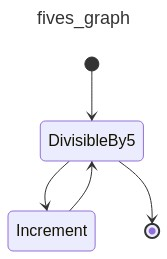

In [21]:
from IPython.display import Image, display
import nest_asyncio
nest_asyncio.apply()

display(Image(fives_graph.mermaid_image(start_node=DivisibleBy5)))



### Stateful Graphs
The "state" concept in `pydantic-graph` provides an optional way to access and mutate an object (often a `dataclass` or Pydantic model) as nodes run in a graph. If you think of Graphs as a production line, then your state is the engine being passed along the line and built up by each node as the graph is run.

In the future, we intend to extend `pydantic-graph` to provide state persistence with the state recorded after each node is run.

Here's an example of a graph which represents a vending machine where the user may insert coins and select a product to purchase.

In [34]:
from __future__ import annotations

from dataclasses import dataclass

from rich.prompt import Prompt

from pydantic_graph import BaseNode, End, Graph, GraphRunContext

import nest_asyncio
nest_asyncio.apply()

@dataclass
class MachineState:
    user_balance: float = 0.0
    product: str | None = None

@dataclass
class InsertCoin(BaseNode[MachineState]):
    async def run(self, ctx: GraphRunContext[MachineState]) -> CoinsInserted:
        return CoinsInserted(float(Prompt.ask('Insert coins')))
    
@dataclass
class CoinsInserted(BaseNode[MachineState]):
    coins: float

    async def run(
            self,
            ctx: GraphRunContext[MachineState]
    ) -> SelectProduct | Purchase:
        ctx.state.user_balance += self.coins
        if ctx.state.product is not None:
            return Purchase(ctx.state.product)
        else:
            return SelectProduct()
        
@dataclass
class SelectProduct(BaseNode[MachineState]):
    async def run(self, ctx: GraphRunContext[MachineState]) -> Purchase:
        return Purchase(Prompt.ask('Select product'))
    
PRODUCT_PRICES = {
    'water': 1.25,
    'soda': 1.50,
    'crisps': 1.75,
    'chocolate': 2.00,
}

@dataclass
class Purchase(BaseNode[MachineState, None, None]):
    product: str

    async def run(
            self, ctx: GraphRunContext[MachineState]
    ) -> End | InsertCoin | SelectProduct:
        if price := PRODUCT_PRICES.get(self.product):
            ctx.state.product = self.product
            if ctx.state.user_balance >= price:
                ctx.state.user_balance -= price
                return End(None)
            else:
                diff = price - ctx.state.user_balance
                print(f'Not enough money for {self.product}, need {diff:0.2f} more')
                #> Not enough money for crisps, need 0.75 more
                return InsertCoin()
        else:
            print(f'No such product: {self.product}, try again')
            return SelectProduct()

vending_machine_graph = Graph(
    nodes=[InsertCoin, CoinsInserted, SelectProduct, Purchase]
)

state = MachineState(1.5)
vending_machine_graph.run_sync(InsertCoin(), state=state)
print(f'purchase succesful item={state.product} change={state.user_balance:0.2f}')
#> purchase successful item=crips change=0.25

Insert coins:

Select product:

purchase succesful item=water change=0.25


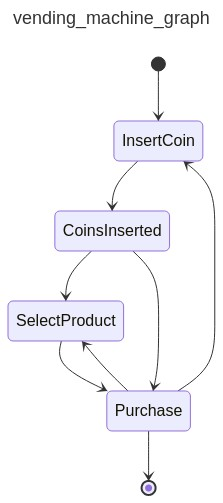

In [33]:
from IPython.display import Image, display
import nest_asyncio
nest_asyncio.apply()

display(Image(vending_machine_graph.mermaid_image(start_node=InsertCoin)))

#### GenAI Example
In this example, one agent generates a welcome email to a user and the other agent provides feedback on the email.

In [4]:
from __future__ import annotations as _annotations

from dataclasses import dataclass, field

from pydantic import BaseModel, EmailStr

from pydantic_ai import Agent
from pydantic_ai.format_as_xml import format_as_xml
from pydantic_ai.messages import ModelMessage
from pydantic_graph import BaseNode, End, Graph, GraphRunContext
from pydantic_ai.models.openai import OpenAIModel
from pydantic_ai.providers.openai import OpenAIProvider
from pprint import pprint as pp

import nest_asyncio
nest_asyncio.apply()

qwen_model = OpenAIModel(
    model_name='qwen2.5-coder:14b', provider=OpenAIProvider(base_url='http://localhost:11434/v1')
)

@dataclass
class User:
    name:str
    email: EmailStr
    interests: list[str]

@dataclass
class Email:
    subject: str
    body: str

@dataclass
class State:
    user: User
    write_agent_messages: list[ModelMessage] = field(default_factory=list)

email_writer_agent = Agent(
    qwen_model,
    result_type=Email,
    system_prompt='Write a welcome email to our tech blog.'
)

@dataclass
class WriteEmail(BaseNode[State]):
    email_feedback: str | None = None

    async def run(self, ctx: GraphRunContext[State]) -> Feedback:
        if self.email_feedback:
            prompt = (
                f'Rewrite the email for the user:\n'
                f'{format_as_xml(ctx.state.user)}\n'
                f'Feedback: {self.email_feedback}'                
            )
        else:
            prompt = (
                f'Write a welcome email for the user;\n'
                f'{format_as_xml(ctx.state.user)}'
            )

        result = await email_writer_agent.run(
            prompt,
            message_history=ctx.state.write_agent_messages
        )
        ctx.state.write_agent_messages += result.all_messages()
        return Feedback(result.data)
    
class EmailRequiresWrite(BaseModel):
    feedback: str

class EmailOk(BaseModel):
    pass

feedback_agent = Agent[None, EmailRequiresWrite | EmailOk](
    qwen_model,
    result_type=EmailRequiresWrite | EmailOk,
    system_prompt=(
        'Review the email and provide feedback, email must reference the users specific interests.'
    )
)

@dataclass
class Feedback(BaseNode[State, None, Email]):
    email: Email

    async def run(
            self,
            ctx: GraphRunContext[State]
    ) -> WriteEmail | End[Email]:
        prompt = format_as_xml({'user': ctx.state.user, 'email': self.email})
        result = await feedback_agent.run(prompt)
        if isinstance(result.data, EmailRequiresWrite):
            return WriteEmail(email_feedback=result.data.feedback)
        else:
            return End(self.email)
        

user = User(
    name='John Doe',
    email='john.joe@example.com',
    interests=['Haskel', 'Lisp', 'Fortran']
)
state = State(user)
feedback_graph = Graph(nodes=(WriteEmail, Feedback))
result = feedback_graph.run_sync(WriteEmail(), state=state)
pp(result.output)
"""
Email(
        subject='Welcome to our tech blog!',
        body='Hello John, Welcome to our tech blog! ...',
    )
"""

Email(subject='Welcome to Our Tech Blog!',
      body='Dear John Doe,\n'
           '\n'
           "Welcome to our tech blog! We're thrilled to have you aboard. As a "
           'fellow enthusiast of languages like Haskell, Lisp, and Fortran, we '
           "believe there's a wealth of knowledge awaiting you here.\n"
           '\n'
           'We cover the latest trends, deep-dives into programming concepts, '
           'and showcases from experts in your favored areas. Feel free to '
           'explore, comment, and share your insights with our community.\n'
           '\n'
           'Once again, welcome aboard! We hope you enjoy your time here and '
           'find this platform a valuable resource for your tech interests.\n'
           '\n'
           'Best regards,\n'
           'The Tech Blog Team')


"\nEmail(\n        subject='Welcome to our tech blog!',\n        body='Hello John, Welcome to our tech blog! ...',\n    )\n"

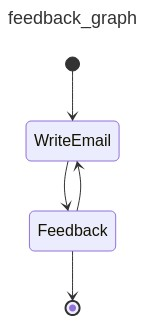

In [5]:
from IPython.display import Image, display
import nest_asyncio
nest_asyncio.apply()

display(Image(feedback_graph.mermaid_image(start_node=WriteEmail)))

In [7]:
pp(state.write_agent_messages)

[ModelRequest(parts=[SystemPromptPart(content='Write a welcome email to our '
                                              'tech blog.',
                                      dynamic_ref=None,
                                      part_kind='system-prompt'),
                     UserPromptPart(content='Write a welcome email for the '
                                            'user;\n'
                                            '<examples>\n'
                                            '  <name>John Doe</name>\n'
                                            '  '
                                            '<email>john.joe@example.com</email>\n'
                                            '  <interests>\n'
                                            '    <example>Haskel</example>\n'
                                            '    <example>Lisp</example>\n'
                                            '    <example>Fortran</example>\n'
                                            '  </i

#### Custom Control Flow
In many real-world applications, Graphs cannot run uninterrupted from start to finish -- they might require external input, or run over an extended period of time such as a single procuss cannot execute the entire graph run from start to finish without interruption.

In these scenarios the `next` method can be used to run the graph one node at a time.

In this example, an AI asks the user a question, the user provides an answer, the AI evaluates the answer and ends if the user got it right or asks another question if they got it wrong.

In [2]:
from __future__ import annotations as _annotations

from dataclasses import dataclass, field

from pydantic_graph import BaseNode, End, Graph, GraphRunContext, HistoryStep

from rich.prompt import Prompt

from pydantic_ai import Agent
from pydantic_ai.format_as_xml import format_as_xml
from pydantic_ai.messages import ModelMessage
from pydantic_ai.models.openai import OpenAIModel
from pydantic_ai.providers.openai import OpenAIProvider

qwen_model = OpenAIModel(
    model_name='qwen2.5-coder:14b', provider=OpenAIProvider(base_url='http://localhost:11434/v1')
)

ask_agent = Agent(qwen_model, result_type=str)

@dataclass
class QuestionState:
    question: str | None = None
    ask_agent_messages: list[ModelMessage] = field(default_factory=list)
    evaluate_agent_messages: list[ModelMessage] = field(default_factory=list)

@dataclass
class Ask(BaseNode[QuestionState]):
    async def run(self, ctx: GraphRunContext[QuestionState]) -> Answer:
        result = await ask_agent.run(
            'Ask a sinple question with a single correct answer.',
            message_history=ctx.state.ask_agent_messages
        )
        ctx.state.ask_agent_messages += result.all_messages()
        ctx.state.question = result.data
        return Answer(result.data)

@dataclass
class Answer(BaseNode[QuestionState]):
    question: str
    answer: str | None = None

    async def run(self, ctx: GraphRunContext[QuestionState]) -> Evaluate:
        assert self.answer is not None
        return Evaluate(self.answer)
    
@dataclass
class EvaluateResult():
    correct: bool
    comment: str

evaluate_agent = Agent(
    qwen_model,
    result_type=EvaluateResult,
    system_prompt='Given a question and answer, evaluate if the answer is correct.'
)

@dataclass
class Evaluate(BaseNode[QuestionState]):
    answer: str

    async def run(
            self, 
            ctx: GraphRunContext[QuestionState]
    ) ->  End[None] | Reprimand:
        assert ctx.state.question is not None
        result = await evaluate_agent.run(
            format_as_xml({'question': ctx.state.question, 'answer': self.answer}),
            message_history=ctx.state.evaluate_agent_messages
        )
        ctx.state.evaluate_agent_messages += result.all_messages()
        if result.data.correct:
            return End(result.data.comment)
        else:
            return Reprimand(result.data.comment)

@dataclass
class Reprimand(BaseNode[QuestionState]):
    comment: str

    async def run(self, ctx: GraphRunContext[QuestionState]) -> Ask:
        print(f'Comment: {self.comment}')
        ctx.state.question = None
        return Ask()
    
question_graph = Graph(nodes=(Ask, Answer, Evaluate, Reprimand))

state = QuestionState()
node = Ask()
history: list[HistoryStep[QuestionState]] = []
while True:
    node = await question_graph.next(node, history, state=state)
    if isinstance(node, Answer):
        node.answer = Prompt.ask(node.question)
    elif isinstance(node, End):
        print(f'Correct answer ! {node.data}')
        #> Correct answer! well done, 1 + 1 = 2
        print([history_step.data_snapshot for history_step in history])
        """
        [
            Ask(),
            Answer(question='What is the capital of France?', answer='Vichy'),
            Evaluate(answer='Vichy'),
            Reprimand(comment='Vichy is no longer the capital of France.'),
            Ask(),
            Answer(question='what is 1 + 1?', answer='2'),
            Evaluate(answer='2'),
            End(data='Well done, 1 + 1 = 2'),
        ]
        """
        break

    


What is the capital of France?:

Comment: The answer provided ('fff') is incorrect. The capital of France is Paris.


What is 2 + 2?:

Comment: The correct answer should be 4.


What is the main function of a CPU in a computer?:

Comment: The answer 'fuck up' is incorrect. The main function of a CPU in a computer is to execute instructions and perform calculations.


What color of light has the shortest wavelength?:

Correct answer ! The answer 'violet' is correct. Violet light indeed has the shortest wavelength among all visible colors.
[<bound method NodeStep.data_snapshot of NodeStep(state=QuestionState(question='What is the capital of France?', ask_agent_messages=[ModelRequest(parts=[UserPromptPart(content='Ask a sinple question with a single correct answer.', timestamp=datetime.datetime(2025, 3, 8, 14, 10, 29, 680763, tzinfo=datetime.timezone.utc), part_kind='user-prompt')], kind='request'), ModelResponse(parts=[TextPart(content='What is the capital of France?', part_kind='text')], model_name='qwen2.5-coder:14b', timestamp=datetime.datetime(2025, 3, 8, 14, 10, 29, tzinfo=datetime.timezone.utc), kind='response')], evaluate_agent_messages=[]), node=Ask(), start_ts=datetime.datetime(2025, 3, 8, 14, 10, 29, 680583, tzinfo=datetime.timezone.utc), duration=0.1703739007934928, kind='node')>, <bound method NodeStep.data_snapshot of NodeStep(state=QuestionState(question='What is the capital of France?'

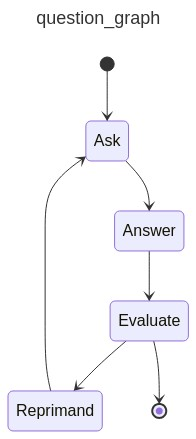

In [3]:
from IPython.display import Image, display
import nest_asyncio
nest_asyncio.apply()

display(Image(question_graph.mermaid_image(start_node=Ask)))